---
# **MVP:** *Machine Learning & Analytics*

**Aluno:** Victor Carlos Teixeira da Costa

**Data:** 25/09/2025

**Matrícula:** 4052024002025

**Dataset:** [New York City Airbnb Open Data](https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data/data)

---

## **1. Definição do Problema**

O mercado de aluguéis de curto prazo, como o do Airbnb, é super dinâmico. Definir o preço certo para um anúncio em uma cidade como Nova York é um desafio enorme. Um preço muito alto pode afastar hóspedes, e um preço muito baixo significa deixar dinheiro na mesa.

Por isso, o objetivo deste projeto é construir um modelo de Machine Learning que ajude a estimar o preço das diárias. A ideia é criar uma ferramenta que possa ser útil tanto para os anfitriões, na hora de precificar seus imóveis, quanto para os hóspedes, para terem uma noção se o valor cobrado é justo.

Tecnicamente, este é um problema clássico de **regressão**, já que nossa variável alvo, o `price`, é um valor numérico contínuo.

### **1.1 Premissas e Hipóteses Iniciais**

Antes de começar a mexer nos dados, pensei em algumas hipóteses que parecem fazer sentido para este problema:

* **Localização é tudo:** Minha principal aposta é que o distrito (`neighbourhood_group`) é o fator que mais vai pesar no preço. Um anúncio em Manhattan deve ser, em média, bem mais caro que um no Bronx.

* **Tipo de quarto importa:** Parece lógico que alugar um apartamento inteiro (`Entire home/apt`) custe mais do que um quarto privado (`Private room`), que por sua vez deve ser mais caro que um quarto compartilhado (`Shared room`).

* **Popularidade e disponibilidade influenciam:** Acredito que anúncios com mais avaliações (`number_of_reviews`) e menor disponibilidade (`availability_365`) possam ter preços um pouco mais altos, por serem mais procurados.

## **1.2 Descrição do Dataset**

Para este trabalho, escolhi o dataset "New York City Airbnb Open Data" do Kaggle. Ele é ideal porque tem um bom volume de dados (quase 49.000 registros de 2019), o que é ótimo para treinar os modelos.

As colunas que parecem mais promissoras para o nosso modelo são: `neighbourhood_group`, `latitude`, `longitude`, `room_type`, `price` (nosso alvo!), `minimum_nights`, `number_of_reviews`, `reviews_per_month`, `calculated_host_listings_count` e `availability_365`.

In [1]:
# 1. Configuração do Ambiente e Carga dos Dados

# Importando os pacotes que vamos usar no projeto
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Uma boa prática que aprendemos: fixar a semente para garantir que os resultados sejam os mesmos se rodarmos o notebook de novo.
np.random.seed(42)
import warnings
warnings.filterwarnings("ignore")

# Carregando o dataset direto de uma URL pública do meu GitHub, como pedido nos requisitos.
url = 'https://raw.githubusercontent.com/victorctc/MVP_Machine_Learning_Airbnb_NY/refs/heads/main/AB_NYC_2019.csv'
df = pd.read_csv(url)

# Dando uma primeira olhada nos dados pra ver se está tudo certo.
print("As 5 primeiras linhas do dataset:")
display(df.head())

print("\nInformações gerais e tipos de dados de cada coluna:")
df.info()

As 5 primeiras linhas do dataset:


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0



Informações gerais e tipos de dados de cada coluna:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 no

## **2. Preparação e Análise Exploratória dos Dados**

Agora começa a parte mais "mão na massa". Antes de treinar qualquer modelo, preciso limpar e entender os dados. Essa etapa é crucial para o sucesso do projeto.

### **2.1. Limpeza dos Dados**

Primeiro, uma boa limpeza. Olhando o `df.info()`, vi alguns pontos de atenção:

* **Dados Faltantes:** A coluna `reviews_per_month` tem valores nulos. Isso acontece quando um anúncio não tem nenhuma avaliação (`number_of_reviews` é 0). Então, o mais correto aqui é simplesmente preencher esses nulos com 0. A coluna `last_review` também tem muitos nulos e não parece ser tão importante para prever o preço, então vou removê-la.

* **Colunas Irrelevantes:** `id`, `name`, `host_id` e `host_name` são identificadores e não devem ajudar o modelo a prever o preço. Vou removê-los. A coluna `neighbourhood` (bairro específico) tem muitos valores únicos (alta cardinalidade), o que complicaria muito nosso modelo (criaria centenas de colunas com OneHotEncoding). Para este MVP, decidi removê-la e focar no `neighbourhood_group` (distrito), que é mais geral.

* **Outliers de Preço:** Analisando a variável `price`, percebi que existem anúncios com preço 0 (o que não faz sentido) e alguns com preços absurdamente altos, como $10.000 a diária. Esses valores extremos podem atrapalhar muito o treinamento. Por isso, decidi remover os preços nulos e limitar o dataset a anúncios com preços até o percentil 99, para manter uma faixa de valores mais realista.

In [2]:
# 2.1: Limpeza dos Dados

# Preenchendo os nulos em 'reviews_per_month' com 0
df['reviews_per_month'].fillna(0, inplace=True)

# Removendo colunas que não vamos usar
df.drop(['id', 'name', 'host_id', 'host_name', 'last_review', 'neighbourhood'], axis=1, inplace=True)

# Dando uma olhada na distribuição dos preços antes de tratar os outliers
# sns.histplot(df['price'], bins=100)
# plt.show()
# O gráfico mostra uma cauda muito longa à direita, confirmando os outliers.

# Filtrando os outliers de preço
price_cap = df['price'].quantile(0.99)
print(f"O valor do percentil 99 para o preço é: ${price_cap:.2f}")
df_cleaned = df[(df['price'] > 0) & (df['price'] <= price_cap)]

print(f"\nO dataset tinha {df.shape[0]} linhas.")
print(f"Após a limpeza, ficamos com {df_cleaned.shape[0]} linhas.")

O valor do percentil 99 para o preço é: $799.00

O dataset tinha 48895 linhas.
Após a limpeza, ficamos com 48410 linhas.


### **2.2. Análise Exploratória (EDA)**

Com os dados mais limpos, fiz alguns gráficos para testar visualmente minhas hipóteses iniciais.

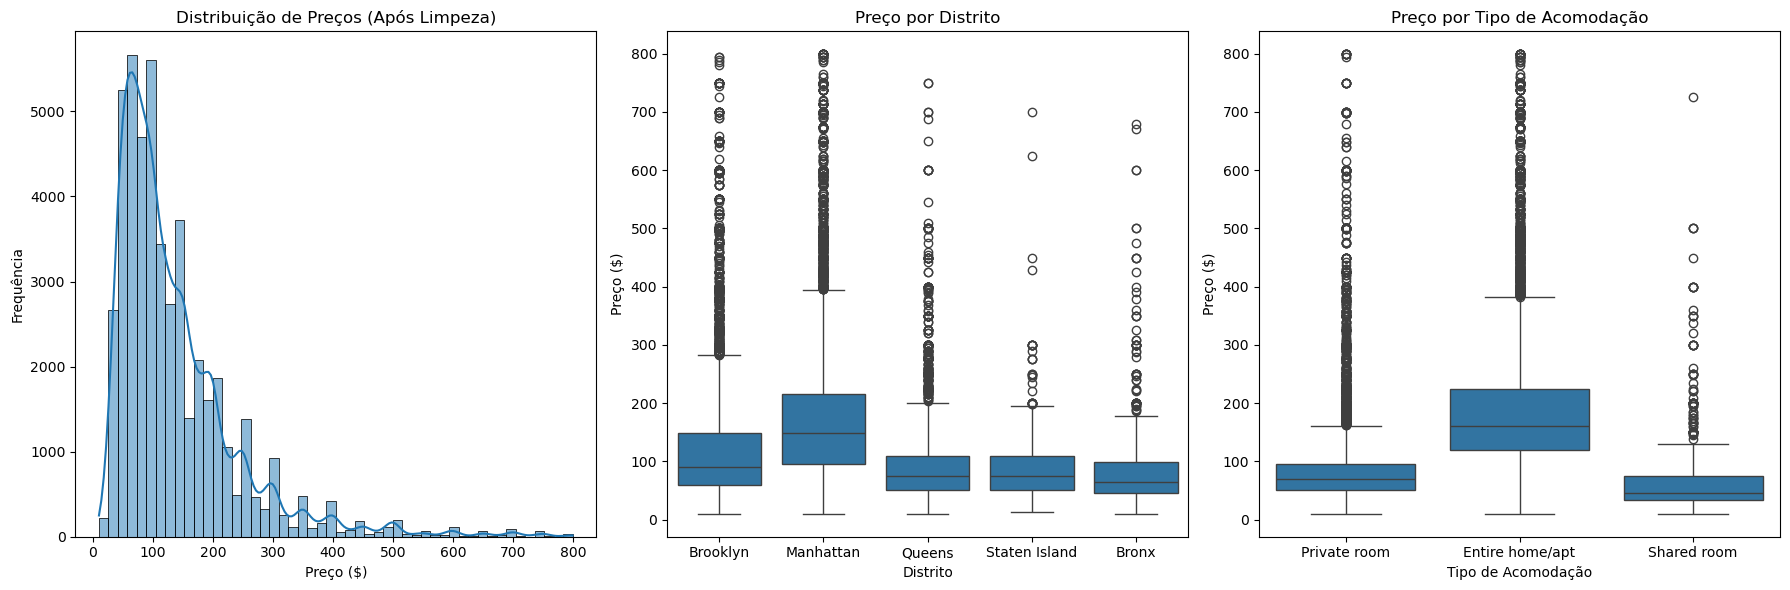

In [3]:
# 2.2: Análise Exploratória Visual

plt.figure(figsize=(18, 6))

# Gráfico 1: Como ficou a distribuição de preços após a limpeza?
plt.subplot(1, 3, 1)
sns.histplot(df_cleaned['price'], kde=True, bins=50)
plt.title('Distribuição de Preços (Após Limpeza)')
plt.xlabel('Preço ($)')
plt.ylabel('Frequência')

# Gráfico 2: Minha hipótese sobre a localização está correta?
plt.subplot(1, 3, 2)
sns.boxplot(data=df_cleaned, x='neighbourhood_group', y='price')
plt.title('Preço por Distrito')
plt.xlabel('Distrito')
plt.ylabel('Preço ($)')

# Gráfico 3: E sobre o tipo de acomodação?
plt.subplot(1, 3, 3)
sns.boxplot(data=df_cleaned, x='room_type', y='price')
plt.title('Preço por Tipo de Acomodação')
plt.xlabel('Tipo de Acomodação')
plt.ylabel('Preço ($)')

plt.tight_layout()
plt.show()

A análise visual confirmou o que eu suspeitava:

1. A **distribuição de preços** continua assimétrica, com a grande maioria dos anúncios custando menos de $200.

2. **Manhattan** é, sem dúvida, o distrito mais caro, validando a **Hipótese 1**.

3. **Entire home/apt** é a categoria mais cara, seguida por **Private room** e **Shared room**, validando a **Hipótese 2**.

### **2.3. Divisão e Transformação Final**

Agora, a última etapa de preparação: dividir os dados em treino e teste e definir como as variáveis serão transformadas para que os modelos consigam "entendê-las".

* **Divisão Treino/Teste:** Vou usar a clássica divisão 80/20.

* **Pré-processamento:**
    * As variáveis categóricas (`neighbourhood_group`, `room_type`) precisam virar números. Vou usar o `OneHotEncoder`.

    * As variáveis numéricas têm escalas muito diferentes (idade, salário, etc.). Vou usar o `StandardScaler` para padronizá-las, o que é muito importante para modelos como Regressão Linear.

Vou montar tudo isso dentro de um `ColumnTransformer`, que é uma ótima prática para organizar o pré-processamento.

In [4]:
# 2.3: Pré-processamento e Divisão

# Separando as features (X) do nosso alvo (y)
X = df_cleaned.drop('price', axis=1)
y = df_cleaned['price']

# Dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Separando os nomes das colunas pelo tipo, para facilitar a criação do pipeline
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = ['neighbourhood_group', 'room_type']

# Criando o objeto preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop' # Garante que nenhuma coluna indesejada passe
)

## **3. Modelagem e Treinamento**

Com os dados prontos, chegou a hora de treinar alguns modelos. A ideia aqui é começar com modelos mais simples e ir para outros mais complexos, para ter uma boa base de comparação.

* **Baseline:** Vou começar com uma **Regressão Linear** para ter um ponto de partida.

* **Modelos Clássicos:** Uma **Árvore de Decisão** para ver como um modelo não-linear simples se sai.

* **Modelos de Ensemble:** **Random Forest** e **Gradient Boosting**, que geralmente são os que trazem os melhores resultados em dados tabulares.

Vou usar a técnica de **Validação Cruzada (com 5 folds)** para ter uma estimativa mais confiável do desempenho de cada modelo, evitando conclusões baseadas em uma única divisão de dados. A métrica principal será o **RMSE (Root Mean Squared Error)**, porque ela me dá o erro na mesma unidade do preço (dólares), o que é fácil de interpretar.

Para organizar tudo e evitar data leakage, vou colocar cada modelo dentro de um `Pipeline` junto com o pré-processamento.

Resultados da Validação Cruzada (RMSE Médio):

Regressão Linear: 83.37 (±1.14)
Árvore de Decisão: 105.63 (±2.13)
Random Forest: 75.11 (±0.83)
Gradient Boosting: 76.82 (±0.92)


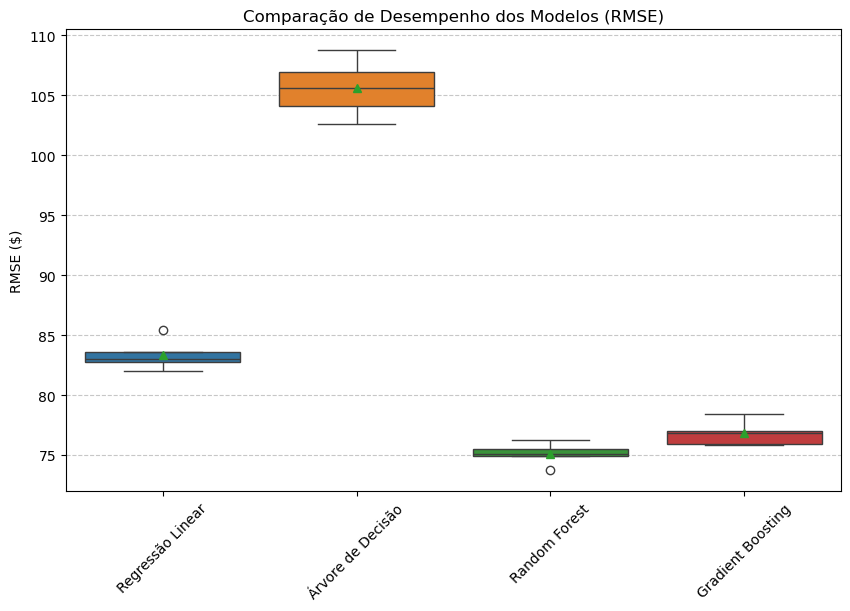

In [5]:
# 3: Comparação de Modelos de Regressão

# Criando um dicionário com os modelos que quero testar
regressors = {
    "Regressão Linear": LinearRegression(),
    "Árvore de Decisão": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

results = []
names = []

print("Resultados da Validação Cruzada (RMSE Médio):\n")
for name, model in regressors.items():
    # Montando o pipeline para cada modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', model)])
    
    # Configurando a validação cruzada
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # O cross_val_score do sklearn maximiza, então usamos 'neg_mean_squared_error' e depois invertemos o sinal
    cv_results = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    
    # Calculando o RMSE e guardando os resultados
    rmse_scores = np.sqrt(-cv_results)
    results.append(rmse_scores)
    names.append(name)
    
    # Imprimindo a média e o desvio padrão do RMSE para cada modelo
    print(f"{name}: {rmse_scores.mean():.2f} (±{rmse_scores.std():.2f})")

# Fazendo um boxplot para comparar visualmente os modelos
plt.figure(figsize=(10, 6))
sns.boxplot(data=results, showmeans=True)
plt.title('Comparação de Desempenho dos Modelos (RMSE)')
plt.ylabel('RMSE ($)')
plt.xticks(ticks=np.arange(len(names)), labels=names, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

***Análise dos Resultados da Modelagem Inicial***

Os resultados da primeira rodada de testes foram bem interessantes:

1. **Ensembles na Frente**: Como esperado, os modelos de ensemble, **Random Forest (RMSE: 75.11)** e **Gradient Boosting (RMSE: 76.82)**, foram muito melhores que os outros. O Random Forest se saiu um pouco melhor e parece ser o mais promissor.

2. **Árvore de Decisão Pura Sofre:** A Árvore de Decisão sozinha teve o pior resultado (**RMSE: 105.63**). Isso mostra bem na prática o seguinte: árvores únicas podem facilmente "decorar" os dados de treino (overfitting) e não generalizam bem.

3. **Regressão Linear como Baseline:** A Regressão Linear teve um RMSE de 83.37. Não é um resultado ruim e serve como um bom baseline, mas fica claro que as relações nos dados são mais complexas do que um modelo linear consegue capturar.

Baseado nisso, vou seguir com o **Random Forest** para a próxima etapa, que é tentar otimizar seus parâmetros para ver se consigo um resultado ainda melhor.

## **4. Otimização de Hiperparâmetros**

Agora que o Random Forest foi escolhido, vou tentar "tunar" seus hiperparâmetros. Usarei o `GridSearchCV` para testar algumas combinações e ver qual delas produz o menor erro, e focarei nos parâmetros que mais costumam impactar o resultado:

* `n_estimators`: Quantas árvores vamos ter na nossa floresta.

* `max_depth`: A profundidade máxima de cada árvore.

* `min_samples_leaf`: Um parâmetro para controlar o overfitting, definindo o número mínimo de amostras que uma folha da árvore deve ter.

In [6]:
# 4: Otimização do Random Forest

# Criando o pipeline que será usado no GridSearch
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))])

# Definindo o "grid" de parâmetros que quero testar
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [10, 20],
    'regressor__min_samples_leaf': [5, 10]
}

# Configurando e rodando o GridSearchCV
grid_search = GridSearchCV(pipeline_rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Mostrando os resultados da otimização
print("\nOtimização de Hiperparâmetros para Random Forest")
best_rmse = np.sqrt(-grid_search.best_score_)
print(f"Melhor RMSE (validação cruzada): {best_rmse:.2f}")
print("Melhores hiperparâmetros encontrados:")
print(grid_search.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits

Otimização de Hiperparâmetros para Random Forest
Melhor RMSE (validação cruzada): 73.80
Melhores hiperparâmetros encontrados:
{'regressor__max_depth': 20, 'regressor__min_samples_leaf': 5, 'regressor__n_estimators': 200}


***Análise da Otimização de Hiperparâmetros***

O `GridSearchCV` encontrou uma combinação de parâmetros que melhorou nosso modelo! O RMSE médio na validação cruzada caiu de 75.11 para 73.80. É uma melhoria pequena, mas que mostra a importância de não se contentar com os parâmetros padrão.

Os melhores parâmetros foram uma `max_depth` de 20, `min_samples_leaf` de 5 e `n_estimators` de 200. Isso indica que o modelo se beneficia de árvores mais profundas e de um número maior de árvores, mas com uma pequena restrição no crescimento para evitar overfitting.

Agora, o teste final: avaliar este modelo otimizado nos dados de teste que guardei desde o início.

## **5. Avaliação Final do Modelo**

Usarei o melhor modelo encontrado pelo Grid Search para fazer previsões no conjunto de teste. Isso me dará uma estimativa real de como o modelo se comportaria com dados novos.

Farei a avaliação usando três métricas:

* **RMSE:** Nosso principal indicador de erro, em dólares.

* **MAE:** O erro absoluto médio, que é menos sensível a erros muito grandes.

* **R²:** O coeficiente de determinação, que nos diz qual a porcentagem da variação dos preços que o nosso modelo consegue explicar.


--- Avaliação Final do Modelo Otimizado ---

RMSE no conjunto de teste: $72.05
MAE no conjunto de teste: $44.16
R² (Coeficiente de Determinação): 0.5229


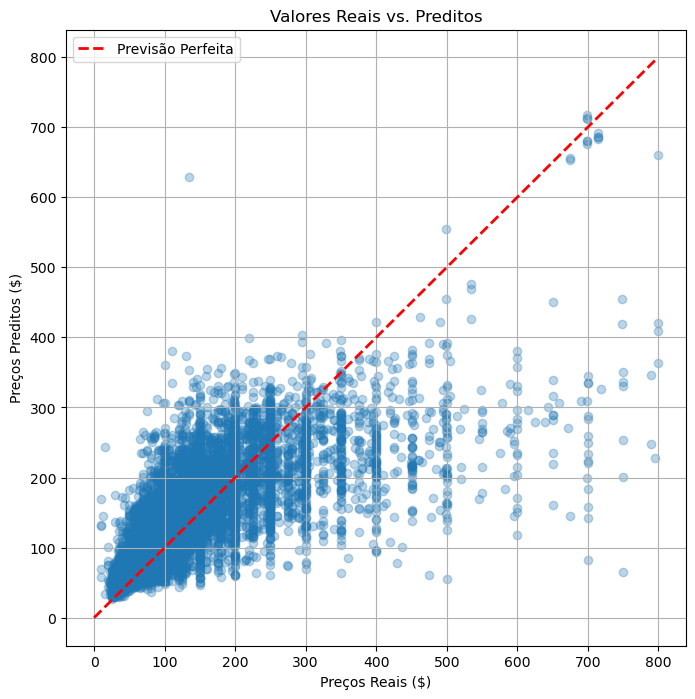

In [7]:
# 5: Avaliação Final no Conjunto de Teste

# Pegando o melhor modelo que o GridSearchCV encontrou
final_model = grid_search.best_estimator_

# Fazendo as previsões no conjunto de teste
y_pred = final_model.predict(X_test)

# Calculando as métricas finais
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- Avaliação Final do Modelo Otimizado ---\n")
print(f"RMSE no conjunto de teste: ${rmse:.2f}")
print(f"MAE no conjunto de teste: ${mae:.2f}")
print(f"R² (Coeficiente de Determinação): {r2:.4f}")

# Gráfico de Dispersão para comparar os valores reais com os previstos
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([0, y_test.max()], [0, y_test.max()], '--', color='red', lw=2, label='Previsão Perfeita')
plt.xlabel('Preços Reais ($)')
plt.ylabel('Preços Preditos ($)')
plt.title('Valores Reais vs. Preditos')
plt.legend()
plt.grid(True)
plt.show()

## **6. Análise de Resultados e Conclusão**

### **6.1. Análise dos Resultados Finais**

O modelo final de **Random Forest otimizado** teve um **RMSE de $72.05** e um **R² de 0.5229** no conjunto de teste.

* O **RMSE** de aproximadamente $72 significa que, em média, as previsões do modelo estão errando por essa quantia. O mais interessante é que esse resultado no teste foi até um pouco melhor que o da validação cruzada (73.80), o que é um ótimo sinal de que não estamos com overfitting. O modelo está generalizando bem.

O **R² de 0.5229** nos diz que o modelo consegue explicar cerca de **52,3% da variação dos preços**. É um resultado razoável. Mostra que nossas features são importantes, mas também que há quase metade da história que não estamos capturando (provavelmente fatores como a qualidade das fotos, as amenidades oferecidas, ou a sazonalidade).

O **gráfico de dispersão** mostra que os pontos seguem a linha de "previsão perfeita", mas com bastante espalhamento, principalmente para os preços mais altos. O modelo é bom para prever os preços na faixa mais comum, mas tem dificuldade com os anúncios mais caros, onde geralmente ele prevê um valor mais baixo que o real.

### **6.2. Conclusão e Próximos Passos**

Conseguimos construir neste MVP um pipeline completo que limpa, prepara e modela os dados para prever os preços do Airbnb em NY. O Random Forest se mostrou um algoritmo muito robusto para este tipo de problema.

***Limitações e Possíveis Melhorias:***

1. **Engenharia de Atributos:** A maior limitação foi ter removido a coluna `neighbourhood`. Em um próximo passo, seria interessante usar técnicas mais avançadas para lidar com ela.

2. **Modelos Mais Potentes:** Poderíamos testar outros algoritmos com melhor performance.

3. **Usar Dados Não Estruturados:** A grande oportunidade de melhoria seria usar as informações de texto da coluna `name` com técnicas de PLN. Extrair palavras-chave como "luxuoso", "perto do metrô" ou "vista incrível" poderia adicionar um poder preditivo enorme ao modelo.